# MMML Lab Assigment 4: Linear Dynamical Systems & Generative Modeling

The aim of this lab assigment is to implement Kalman filter for two-dimensional data and observe its effect on real-world example of eye-tracking experiment as well as explore and implement generative modelling on examples of GANs and VAEs.

We will discuss:
* LDS sampling and whether Kalman filter indeed makes the improvement of the data correspondance
* Theoretical background behind Generative Adversarial Networks (GANs)
* Variational AutoEncoder (VAE) model and it's application to the MNIST distribution learning/generation

Answering all questions will bring 7 points out of the total course grade.

### Instructions

1.   Form a team of two
2.   Rename the ipynb file to `Name1_Name2_MMML_Lab4.ipynb`
3.   Indicate team members at the top
4.   Provide your solutions (code or explanation) as necessary; do not reshuffle the cell order! You are welcome to optimize the existing commands if you want
5.   Please execute all the cells before submission; make sure there are no errors, all plots have been generated, and all numerical answers calculated. Also, do not make *looong* prints
6.   Submit your notebook to **cms** along with the pdf output.  


### Import needed libraries

In [2]:
!pip  install pykalman
# Imports
import sys
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import pykalman
from scipy import stats
import plotly.graph_objects as go
from sklearn.metrics import r2_score

from typing import List, Tuple, OrderedDict
from collections import OrderedDict
import warnings
import io
import ipywidgets as widgets
warnings.filterwarnings("ignore")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.6/251.6 kB 1.7 MB/s eta 0:00:00


### Util functions

In [ ]:
def plot_lds(state, observations, filtered_observations = None):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x = state[:, 0], y = state[:, 1], mode = 'lines', name = "Hidden (True) State"))
    fig.add_trace(go.Scatter(x = observations[:, 0], y = observations[:, 1], mode = 'lines', name = "Observed (Measured) State"))
    if filtered_observations:
        fig.add_trace(go.Scatter(x = filtered_observations[:, 0], y = filtered_observations[:, 1], mode = 'lines', name = "Filtered Observed State"))
    fig.update_layout(title='LDS')
    return fig

def plot_correlation_lds(state, observations, annotation):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x = state[:, 0], y = observations[:, 0], mode = 'markers', name = "1st dimension"))
    fig.add_trace(go.Scatter(x = state[:, 1], y = observations[:, 1], mode = 'markers', name = "2nd dimension"))
    fig.update_layout(title='Correlation', yaxis_title = annotation, xaxis_title = "Hidden states")
    fig.update_xaxes(scaleanchor = "y", scaleratio = 1, constrain = "domain")
    return fig

def load_eyetracking_data(data_fname):

  with np.load(data_fname, allow_pickle=True) as dobj:
    data = dict(**dobj)

  images = [plt.imread(io.BytesIO(stim), format='JPG')
            for stim in data['stimuli']]
  subjects = data['subjects']

  return subjects, images

## 1. 2D Linear Dynamical Systems (2 pts)

## 1.1 Kalman Filter for 2D LDS (1 pt)

Remember that Linear Dynamical System is a special case of State Space Model (SSM) where hidden states are continuous. In general, the dynamics of the system are described via the following equations:

$$\mathbf{z}_{n} = \mathbf{A}\mathbf{z}_{n-1} + \mathbf{w}_{n}$$
$$\mathbf{x}_{n} = \mathbf{C}\mathbf{z}_{n} + \mathbf{v}_{n}$$
$$\mathbf{z}_{1} = \mathbf{\mu}_{0} + \mathbf{u}$$

where $\mathbf{w}_{n} \sim \mathcal{N}(\mathbf{0}, \mathbf{\Gamma})$, $\mathbf{v}_{n} \sim \mathcal{N}(\mathbf{0}, \mathbf{\Sigma})$, $\mathbf{u} \sim \mathcal{N}(\mathbf{0}, \mathbf{V}_{0})$ all being Gaussian noises with zero means.

Here, $\mathbf{z}_{n}$ is a hidden state (true value); observe that it depends only on the previous state $\mathbf{z}_{n-1}$ plus some process-dependent Gaussian noise. Then, $\mathbf{x}_{n}$, the observed value, is a linear transformation of hidden one, $\mathbf{z}_{n}$, plus some measurement-dependent Gaussian noise. The initial hidden state is also a subject to the noise $\mathbf{u}$.

Kalman filter is the algorithm which allows us to correct for the prediction of the following true value by incorporating knowledge about the measurement. Suppose, we know $\mathbf{z}_{n-1}$, then the best prediction (prior) we can make about the next hidden state is $\mathbf{A}\mathbf{z}_{n-1}$ but we also have another source of the information - our measurement (observation) $\mathbf{x}_{n}$; Kalman filter enables us with efficient integration of both information sources to get the best prediction we can do. In the very end of the derivations, it tell us that:

$$\mathbf{\mu}_{n} = \mathbf{A}\mathbf{\mu}_{n-1} + \mathbf{K}_{n}(\mathbf{x}_{n} - \mathbf{C} \mathbf{A} \mathbf{\mu}_{n-1})$$
$$\mathbf{V}_{n} = (\mathbf{I} - \mathbf{K}_{n}\mathbf{C})\mathbf{P}_{n-1}$$

where $\mathbf{K}_{n}$ is a Kalman gain which basically tells us how much of the attention we should pay to the prior (dynamical system prediction) vs to the likelihood (observation) depending on the values of the noise:
$$\mathbf{K}_{n} = \mathbf{P}_{n-1}\mathbf{C}^{T}(\mathbf{C}\mathbf{P}_{n-1}\mathbf{C}^{T} + \mathbf{\Sigma}^{-1})$$

One more variable to be discussed here and it is $\mathbf{P}_{n-1}$ matrix which corresponds to the noise of the posterior distribution of $\mathbf{z}_{n}$ after applying dynamics of the system (but before incorporating the likelihood!). It is calculated as following:

$$\mathbf{P}_{n-1} = \mathbf{A}\mathbf{V}_{n-1}\mathbf{A}^{T} + \mathbf{\Gamma}$$

### 1.1.1 Sampling from 2D LDS (0.25 pts)

In the exercise below you are suggested to sample from the LDS and observe the differnce between hidden and measured states.

In [ ]:
n_dim = 2

# initialize model parameters
params = {
  'n_dim': 2, # dimensionality of the hidden and observed states (in general, not necessarily equal!)
  'A': 0.9 * np.eye(n_dim),  # state transition matrix
  'Gamma': np.eye(n_dim),  # state noise covariance
  'C': np.eye(n_dim),  # observation matrix
  'Sigma': 1.0 * np.eye(n_dim),  # observation noise covariance
  'mu_0': np.zeros(n_dim),  # initial state mean
  'V_0': 0.1 * np.eye(n_dim),  # initial state noise covariance
}

In [ ]:
np.random.seed(42)

def sample_lds(n_timesteps, params):
  """ Generate samples from a Linear Dynamical System specified by the provided
  parameters.

  Args:
  n_timesteps (int): the number of time steps to simulate
  params (dict): a dictionary of model parameters

  Returns:
  ndarray, ndarray: the generated state and observation data
  """

  state = np.zeros((n_timesteps, n_dim))
  observations = np.zeros((n_timesteps, n_dim))

  # ========= YOUR CODE STARTS HERE ========= #

  # ========== YOUR CODE ENDS HERE ========== #


  return state, observations


n_timesteps = 100
state, observations = sample_lds(n_timesteps, params)

fig = plot_lds(state, observations)
fig.show()

Observe that observation matrix for this particular LDS is identity matrix, meaning that we expect for the perfect correspondence between hidden and observed states (not counting for the noise). Let us check for it by plotting correlation between each of the dimensions for this data.

In [ ]:
fig = plot_correlation_lds(state, observations, annotation = "Measurements")
fig.show()

Not the perfect line!

Let us also quantify the discrepancy induced by the noise; for that we will calculate R-squared score (observe the way we do so; you will have discussion question in the end of the exercise for that).

In [ ]:
print(f"R2-score for 1st dimension of observations is {r2_score(state[:, 0], observations[:, 0]):.02f}")
print(f"R2-score for 2nd dimension of observations is {r2_score(state[:, 1], observations[:, 1]):.02f}")

### 1.1.2 Kalman Filter for 2D Data (0.5 pts)

Now we are ready to implement Kalman filter for the given system (well. your function should be generalized version for any set of parameters and any dimensionality) and observe whether it improves the situation with the predictability of the true state.

In [ ]:
def kalman_filter(observations, params):
  """ Perform Kalman filtering (forward pass) on the data given the provided
  system parameters.

  Args:
    observations (ndarray): a sequence of observations of shape(n_timesteps, n_dim)
    params (dict): a dictionary of model parameters

  Returns:
    ndarray, ndarray: the filtered system means and noise covariance values
  """
  # ========= YOUR CODE STARTS HERE ========= #

  # ========== YOUR CODE ENDS HERE ========== #

  return mu, sigma


filtered_state_means, filtered_state_covariances = kalman_filter(observations, params)

fig = plot_correlation_lds(state, filtered_state_means, annotation = "Filtered measurements")
fig.show()

We also calculate R-squared score here.

In [ ]:
print(f"R2-score for 1st dimension of observations is {r2_score(state[:, 0], filtered_state_means[:, 0]):.02f}")
print(f"R2-score for 2nd dimension of observations is {r2_score(state[:, 1], filtered_state_means[:, 1]):.02f}")

### 1.1.3 R-squared improvement (0.25 pts)

Why do we calculate R-squared value explicitly on this arrays of data? Will we have the same way to do that if matrix $\mathbf{C}$ is no longer identity one?

Why do you think R-squared value has improved? Do we expect it to increase after filtering?

## 1.2 Real-world application of Kalman Filter (1 pt)

Kalman Filter is an extremely widely-used method in online application where data points drop to us one by one and we would like somehow to filter for outliers and smooth the general data. In this part of the lab task, you are going to fit 2D LDS using EM-method already implemented in the library `pykalman` for the eye-tracking dataset where people watched the images and location of their gaze was measured (of course, these measurements are subjects to noise as it is pretty hard to reliably estimate the exact gaze fixation position, even for us, as we move our eyes a lot in an unconscious manner).

We will take a look at 3 images and 5 different subjects watching them. Each subject fixated in the center of the screen before the image appeared, then had a few seconds to freely look around. At first, let us read the data.

In [ ]:
subjects, images = load_eyetracking_data("eyetracking.npz")

In the widget below you can explore eyetracking data gathered for different subjects and images (if you want to see clear image without data, please choose `subject_id = -1`).

In [ ]:
@widgets.interact(subject_id=widgets.IntSlider(-1, min=-1, max=4),
                  image_id=widgets.IntSlider(0, min=0, max=2))
def plot_subject_trace(subject_id=-1, image_id=0):
  if subject_id == -1:
    subject = np.zeros((3, 0, 2))
  else:
    subject = subjects[subject_id]
  data = subject[image_id]
  img = images[image_id]

  fig, ax = plt.subplots()
  ax.imshow(img, aspect='auto')
  ax.scatter(data[:, 0], data[:, 1], c='m', s=100, alpha=0.7)
  ax.set(xlim=(0, img.shape[1]), ylim=(img.shape[0], 0))
  plt.show(fig)

interactive(children=(IntSlider(value=-1, description='subject_id', max=4, min=-1), IntSlider(value=0, descrip…

### 1.2.1 Fitting data with `pykalman` (0.25 pts)

Learning algorithm for LDS is too complex to be covered during our course. Thus, we will simply use the external library which will help us to fit the parameters using EM-method. Observe that we will provide initial state mean and covariance manually, thus we will fit all other parameters (you need to specify them in `em_vars`) using EM (here is the [link](https://pykalman.github.io/) to the documentation).

In [ ]:
# ========= YOUR CODE STARTS HERE ========= #
kf = pykalman.KalmanFilter(
  n_dim_state=...,
  n_dim_obs=...,
  em_vars=...
)
# ========== YOUR CODE ENDS HERE ========== #

subject_id = 1
image_id = 1
data = subjects[subject_id][image_id]

kf.initial_state_mean = data[0]
kf.initial_state_covariance = 0.1*np.eye(2)
kf.em(data)

# ========= YOUR CODE STARTS HERE ========= #
print(f'A =\n{...}')
print(f'Gamma =\n{...}')
print(f'C =\n{...}')
print(f'Sigma =\n{...}')
# ========== YOUR CODE ENDS HERE ========== #

**Question to be answered**: What can you say about the process while taking a look at the fitted dynamical parameters?

*Your thoughts go here*

### 1.2.2 Custom Kalman filter vs `pykalman.filter()` (0.25 pts)


Let us compare the results of our custom Kalman filter implemeted earlier and the one proposed in `pykalman` filter. For that, we need to prepare fitted parameters in the corresponding format to use our function.

In [ ]:
# ========= YOUR CODE STARTS HERE ========= #
params = {

}
# ========== YOUR CODE ENDS HERE ========== #

filtered_state_means_custom, filtered_state_covariances_custom = kalman_filter(data, params)

# ========= YOUR CODE STARTS HERE ========= #
filtered_state_means_pykalman, filtered_state_covariances_pykalman = ...

# ========== YOUR CODE ENDS HERE ========== #

print(f"Wow, we implemented Kalman filter correctly: {np.allclose(filtered_state_means_custom, filtered_state_means_pykalman)}")

### 1.2.3 Discussion points (0.5 pts)


In this exercise, we would like you to think about the experience you've just had so that you could get the broad picture of Kalman filter usage. Please answer the following questions (some of them will require you to do the small experiment to justify your answer):

1. Do you think that Linear Dynamical System is the right choice for the modeling the underlying dynamics of eye gazing? Why yes / why no?
2. Run the Kalman filter on the fitted parameters for other subjects and images as well, what do you think of its quality (calculate some metrics to justify your ideas)? Why do you think it is the way it is (performs poorly or generalizes well - depending what you have obtained)?
3. Sample from Kalman filter - what do you think of predicitve power for our system? Does it make sense to tell that we have developed the tool which is able to say where the person is doing to look in the next time point? Which of the factros have more impact - prior or measurement (hint: you may want to look at Kalman gain value)?

## 1.3 Kalman smoother (additional, up to 1.5 pts)


Whenever we are presented with the whole sequence (but not online updates), we can benfit from backward pass of the data, as the future states also can tell us about the nature of previous ones. Analogue of Backward algorithm for LDS is Kalman smoother. This additional task requires you to implement your own Kalman smoother (0.5 pts) as well as write down mathematical structures which are necessary for this implementation (0.5 pts). Then, please compare the results of Kalman filter and Kalman smoother, as $\mathbf{C}$ isn't the identity matrix (up to certain level of confidence), what other metric you would suggest using to compare their work (0.5 pts)?

In [ ]:
# ========= YOUR CODE STARTS HERE ========= #

# ========== YOUR CODE ENDS HERE ========== #

## 2. Generative modelling (5 pts)

### 2.1 Generative Adversarial Networks (GANs) (1.25 pts)

GANs is a very interesting, yet powerful approach to the generative modelling. In the GANs paradigm, we learn data distribution $p_{data}$ implicitly - via an adversarial training between two networks: Generator $G$ and Discriminator $D$. We aim to make generator distribution $p_g$ a good approximation to the data distribution $p_{data}$. The generator distribution is learned as mapping from some simple prior distribution $p_Z(z)$ to the data. Later, our Discriminator takes as input true samples (from $p_{data}$) and generated samples (from $p_g$) and tries to differentiate between them. As output of our Discriminator, we expect to see the probability of sample being from the data distribution ($p_{data}$). Discriminator tries to correctly guess whether samples is true or fake, and Generator tries to fool the Discriminator by creating realistic samples.

More formally, $D$ and $G$ play the following two-player minimax game with value function $V(G, D)$:

$$
\min_G \max_D V(G, D) = \mathbb{E}_{x \sim p_{data}(x)}[\log D(x)] + \mathbb{E}_{z \sim p_Z(z)}[\log(1 - D(G(z)))]
$$

In this section, we'll analyze why $p_g = p_{data}$ is the global optimum of the objective above (which is good, as that's what we want our generator to learn)

#### 2.1.1 Optimal discriminator (0.5 pts)

Prove that for fixed $G$ optimal discriminator $D$ is:

$$
D_G^*(x) = \frac{p_{data}(x)}{p_{data}(x) + p_g(x)}
$$

Note that when we have optimal discriminator $D_G^*(x)$, the objective for generator $C(G)$ can be defined as follows:

$$
C(G) = \max_D V(G, D) = \mathbb{E}_{x \sim p_{data}(x)}[\log D_G^*(x)] + \mathbb{E}_{z \sim p_Z(z)}[\log(1 - D_G*(G(z)))]
$$

$$
= \mathbb{E}_{x \sim p_{data}(x)}[\log D_G^*(x)] + \mathbb{E}_{x \sim p_g(x)}[\log(1 - D_G^*(x))]
$$

$$
= \mathbb{E}_{x \sim p_{data}(x)}[\log \frac{p_{data}(x)}{p_{data}(x) + p_g(x)}] + \mathbb{E}_{x \sim p_g(x)}[\log \frac{p_g(x)}{p_{data}(x) + p_g(x)}]
$$

##### Proof

Optimal $D^*_G(x)$ maximizes $C(G)$. Using the definition of the expected value, $C(G)$ can be rewritten as $$\int_x{[p_{data}(x)log(D^*_G(x)) + p_{g}(x)log(1-D^*_G(G(x)))]dx} $$

To maximize this objective, it is sufficient to find $D^*_G(x)$ that maximizes $p_{data}(x)log(D^*_G(x)) + p_{g}(x)log(1-D^*_G(G(x)))$ under the integral. It is an expression of type $$f(x) = a\log{(x)} + b\log{(1-x)}$$. Its derivative is equal to $$f(x)'_x=\frac{a}{x} - \frac{b}{1-x} = \frac{a-ax-bx}{x-x^2}$$. Assuming $x \in (0,1)$ (since the output of $D^*_G(x)$ is likelihood of x from 0 to 1), there is only one critical point where the derivative is equal to zero:
$$a-ax^*-bx^*=0 $$
$$ x^*(a+b) = a $$
$$ x^* = \frac{a}{a+b}$$

The second derivative of $f(x)$ is $$f(x)''_x = -\frac{a}{x^2} - \frac{b}{(1-x)^2} = - (\frac{a}{x^2} + \frac{b}{(1-x)^2})$$
which is always negative for $a, b > 0$, thus the funciton is concave.
Therefore, the critical point $x^* = \frac{a}{a+b}$ is the point of global maxima of $f(x) = a\log{(x)} + b\log{(1-x)}$ and thus, the such $D^*_G(x)$ that maximizes $p_{data}(x)log(D^*_G(x)) + p_{g}(x)log(1-D^*_G(G(x)))$ is equal to $$\frac{p_{data}(x)}{p_{data}(x)+p_g(x)}$$

#### 2.1.2 Optimal generator (0.5 pts)

Prove that the global minimum of the generator objective $C(G)$ (when we have optimal discriminator) is achieved if and only if $p_g = p_{data}$. Show that at this point, $C(G)$ achieves value $-\log 4$.

For optimal discriminator $D^*_G(x)=\frac{p_{data}}{p_{data}+p_g}$ we have $C(G) = \mathbb{E}_{x ~ p_{data}}[\log(\frac{1}{2})] + \mathbb{E}_{x ~ p_g}[\log(1-\frac{1}{2})] = \log(\frac{1}{2} * \frac{1}{2}) = -\log4$.

Let us also proof the statement backwards (if the value is equal to $\log4$, it is optimal)

$$C(G) = \int_x [p_{data}\log(\frac{p_{data}}{p_g+p_{data}}) + p_{g}\log(1-\frac{p_{data}}{p_g+p_{data}})]dx =$$
$$\int_x [p_{data}\log(\frac{p_{data}}{p_g+p_{data}}) + p_{g}\log(\frac{p_g}{p_g+p_{data}})]dx =$$
$$\int_x [(\log2-\log2)(p_{data}+p_g) + p_{data}\log(\frac{p_{data}}{p_g+p_{data}}) + p_{g}\log(\frac{p_g}{p_g+p_{data}})]dx =$$
$$-\log2 * \int_x [p_{data}+p_g]dx + \int_x [p_{data}(\log2+\log(\frac{p_{data}}{p_g+p_{data}})) + p_{g}(\log2+\log(\frac{p_g}{p_g+p_{data}}))]dx =$$
$$-2\log2 + \int_x [p_{data}(\log\frac{p_{data}}{\frac{p_g+p_{data}}{2}}) + p_g(\log\frac{p_g}{\frac{p_g+p_{data}}{2}})]dx = $$
$$-\log4 + \int_x [p_{data}(\log\frac{p_{data}}{\frac{p_g+p_{data}}{2}})]dx + \int_x [p_{g}(\log\frac{p_{g}}{\frac{p_g+p_{data}}{2}})]dx = $$
$$-\log4 + KL(p_{data} || \frac{p_{data}+p_g}{2}) + KL(p_{g} || \frac{p_{data}+p_g}{2}) = $$
$$-\log4 + 2 * JSD(p_{data}||p_g)$$
since Jensen-Shannon divergence is always non-negative, and equals zero if and only if both of the distributions are the same, the optimal value of $C(G)$ is not less than $-\log4$ and is obtained in point where $p_{data} = p_g$

### 2.1.3 Summary (0.25 pts)

* From the theorems proven above, how would you train your GANs model? Would we converge to the $p_g = p_{data}$ with such training?

To achieve convergence we must train our generator and discriminator simultaneously or at least balanced, in order not to let the generator exploit some outlier data points which are hard for discriminator to distinguish from fake data points and soon **mode collapse** will happen i.e. the generator will focus **only** on the those exploitable outlier datapoints.

Also, we would like to stop when the loss value is not decreasing anymore, since it indicates that discriminator is "perfect" and the generator does not actually improves since it cannot "win" the discriminator. We can evaluate the performance of out generator by looking how close the loss is to $-\log4$

* Summarize in a few sentences what you have learned and achieved by completing the tasks of this assignment. Comment on how this assignment can be imporved in the future.

It was a very interesting task to understand how math proofs from *relatively* recent ML papers actually work.

It is also interesting how game theory framework is applied to the task of generative models and how some of the constants, such as optimal value to which $C(G)$ converges, can be derived in closed form.

Also, the paper on GAN itself is written nicely, except of it was not really clear how "by subtracting this expression from C(G) = V (D∗G, G), we obtain *an equation with two KL-divergences introduced*". However, the paper is popular, so it was not hard to look for additional explanations.

### 2.2 Variational AutoEncoders (VAEs) (3.75 pts)

Variational AutoEncoder (VAE) is a specific type of Latent Variable Model (LVM). In LVM paradigm, we assume that our data $x$ can be modelled via some hidden (unobserved) and semantically meaningful variable $z$. VAE is defined in the following way:

* latent variables $z$ have a standard normal prior $p_Z(z) = \mathcal{N}(0, I)$
* an approximate posterior $q_{\phi}(z|x) = \mathcal{N}(\mu_{\phi}(x), \Sigma_{\phi}(x))$, where $\mu_{\phi}(x)$ is the mean vector and $\Sigma_{\phi}(x)$ is a diagonal covariance matrix
* a decoder $p_{\theta}(x|z) = \mathcal{N}(\mu_{\theta}(z), \Sigma_{\theta}(z))$, where $\mu_{\theta}(z)$ is the mean vector and $\Sigma_{\theta}(z)$ is a diagonal covariance matrix

#### 2.2.1 VAEs on 2D data (2 pts)

In this question, you will train a simple VAE on 2D data.

Firstly, let's generate and visualize our data:

In [10]:
def sample_2d_data(count: int) -> np.ndarray:
    rand = np.random.RandomState(0)
    samples = [[1.0, 2.0]] + (rand.randn(count, 2) * [[5.0, 1.0]]).dot(
        [[np.sqrt(2) / 2, np.sqrt(2) / 2], [-np.sqrt(2) / 2, np.sqrt(2) / 2]])
    return samples.astype(np.float32)

train_data, test_data = sample_2d_data(10000), sample_2d_data(2500)

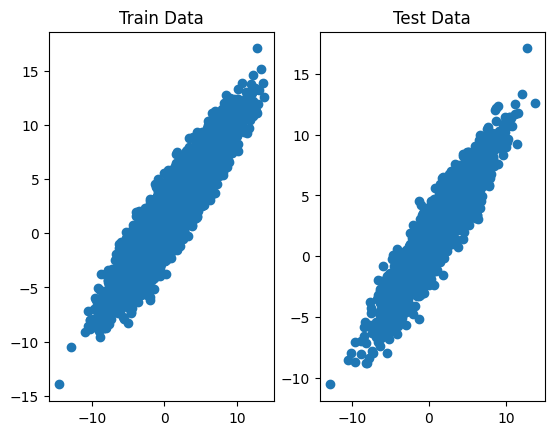

In [11]:
def visualize_2d_data(train_data: np.ndarray, test_data: np.ndarray):
    _, (ax1, ax2) = plt.subplots(1, 2)
    ax1.set_title('Train Data')
    ax1.scatter(train_data[:, 0], train_data[:, 1])
    ax2.set_title('Test Data')
    ax2.scatter(test_data[:, 0], test_data[:, 1])
    plt.show()

visualize_2d_data(train_data, test_data)

These are some utils functions, which will be used later:

In [12]:
def plot_vae_training_plot(train_losses: np.ndarray, test_losses: np.ndarray, title: str):
    vlb_train, recon_train, kl_train = train_losses[:, 0], train_losses[:, 1], train_losses[:, 2]
    vlb_test, recon_test, kl_test = test_losses[:, 0], test_losses[:, 1], test_losses[:, 2]
    plt.figure()
    n_epochs = len(test_losses) - 1
    x_train = np.linspace(0, n_epochs, len(train_losses))
    x_test = np.arange(n_epochs + 1)

    plt.plot(x_train, vlb_train, label='-vlb_train')
    plt.plot(x_train, recon_train, label='recon_loss_train')
    plt.plot(x_train, kl_train, label='kl_loss_train')
    plt.plot(x_test, vlb_test, label='-vlb_test')
    plt.plot(x_test, recon_test, label='recon_loss_test')
    plt.plot(x_test, kl_test, label='kl_loss_test')

    plt.legend()
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

def scatter_2d(data: np.ndarray, title: str):
    plt.figure()
    plt.title(title)
    plt.scatter(data[:, 0], data[:, 1])

##### 2.2.1.1 VAE Encoder and Decoder (0.25 pts)

Implement VAE Encoder and Decoder. Our latent variables $z$ dimensionality here will be 2 (for visualizations). The recommended architecture is following:

```
linear(in_dim, out_dim)
relu()

Encoder
    linear(2, 128)
    relu()
    linear(128, 128)
    relu()
    linear(128, 2*2) # 2 - for mu and 2 - for sigma

Decoder
    linear(2, 128)
    relu()
    linear(128, 128)
    relu()
    linear(128, 2*2) # 2 - for mu and 2 - for sigma
```

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_shape: int, output_shape: int, hiddens: List[int]):
        super().__init__()
        # ========= YOUR CODE STARTS HERE ========= #
        self.layers = nn.Sequential(
            nn.Linear(input_shape, hiddens[0]),
            nn.ReLU(),
            nn.Linear(hiddens[0], hiddens[1]),
            nn.ReLU(),
            nn.Linear(hiddens[1], 2 * output_shape)
        )
        # ========== YOUR CODE ENDS HERE ========== #

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # ========= YOUR CODE STARTS HERE ========= #
        output = self.layers(x)
        # ========== YOUR CODE ENDS HERE ========== #
        return output


class Decoder(nn.Module):
    def __init__(self, input_shape: int, output_shape: int, hiddens: List[int]):
        super().__init__()
        # ========= YOUR CODE STARTS HERE ========= #
        self.layers = nn.Sequential(
            nn.Linear(input_shape, hiddens[0]),
            nn.ReLU(),
            nn.Linear(hiddens[0], hiddens[1]),
            nn.ReLU(),
            nn.Linear(hiddens[1], 2 * output_shape)
        )
        # ========== YOUR CODE ENDS HERE ========== #

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # ========= YOUR CODE STARTS HERE ========= #
        output = self.layers(x)
        # ========== YOUR CODE ENDS HERE ========== #
        return output

##### 2.2.1.2 KL-divergence between 2 Gaussian Distributions (0.5 pts)

Recall that KL-divergence between 2 arbitratry distributions $p$ and $q$ is defined as follows:

$$
D_{KL}(p \parallel q) = \mathbb{E}_{x \sim p(x)} \log \frac{p(x)}{q(x)}
$$

When our distributions $p$ and $q$ are Multivariate Gaussians ($p = \mathcal{N}(\mu_p, \Sigma_p)$, $q = \mathcal{N}(\mu_q, \Sigma_q)$) in $d$ dimensions, derive the formula for KL-divergence between them.

Simplify the formula for $q$ being Standard Gaussian ($q = \mathcal{N}(0, I)$).

Hint: For $x \sim \mathcal{N}(\mu, \Sigma), E[(x-m)A(x-m)^T] = (\mu-m)A(\mu-m)^T + \operatorname{trace}(A\Sigma)$

For $p\sim \mathcal{N}(\mu_p, \Sigma_p)$ and $q \sim \mathcal{N}(\mathbf{0}, I)$:

$$
\mathbb{E}_{x \sim p(x)} \log \frac{p(x)}{q(x)} = \mathbb{E}_{x \sim p(x)} \log [\frac{1}{\sqrt{\det(\Sigma_p)}} * \exp\{-\frac{1}{2}(x-\mu_p)^T\Sigma_p^{-1}(x-\mu_p) + \frac{1}{2}x^T\Sigma_q^{-1}x\}] =
$$

$$
\mathbb{E}_{x \sim p(x)}[ \log (\frac{1}{\sqrt{\det(\Sigma_p)}}) -\frac{1}{2}(x-\mu_p)^T\Sigma_p^{-1}(x-\mu_p) + \frac{1}{2}x^T\Sigma_q^{-1}x] =
$$
$$
\log (\frac{1}{\sqrt{\det(\Sigma_p)}}) - \mathbb{E}_{x \sim p(x)} [\frac{1}{2}(x-\mu_p)^T \Sigma_p^{-1}(x-\mu_p)] + \frac{1}{2}\mu_p^T\mu_p + \frac{1}{2}\operatorname{trace}(\Sigma_q^{-1}\Sigma_p)=
$$

$$
\log (\frac{1}{\sqrt{\det(\Sigma_p)}}) - \frac{1}{2}(\mu_p - \mu_p)^T\Sigma_p^{-1}(\mu_p-\mu_p) - \frac{1}{2}\operatorname{trace}(\Sigma_p^{-1}\Sigma_p) + \frac{1}{2}\mu_p^T\mu_p + \frac{1}{2}\operatorname{trace}(\Sigma_p)=
$$

$$
-\frac{1}{2}\log (\det(\Sigma_p)) - \frac{1}{2}\operatorname{dim}(\mu_p) + \frac{1}{2}\mu_p^T\mu_p + \frac{1}{2}\operatorname{trace}(\Sigma_p)
$$

##### 2.2.1.3 VAE implementation (0.5 pts)

Implement the code for VAE below:
* output shape of encoder and decoder should be $2 * \text{latent\_dim}$ and $2*\text{input\_dim}$ respectively as we predict both $\mu$ and $\Sigma$
* as our $\Sigma$ is diagonal (by design) and must be positive-semidefinite, we predict logarithm of $\Sigma$ and later exponentiate it
* in this task, our Decoder also produces Gaussian distribution, from which we should sample our data point $x$ (or calculate probability of seeing it in the reconstruction loss).
* when computing reconstruction loss and KL loss, average over the batch dimension and **sum** over the feature dimension

Our loss is defined as (minus) Variational Lower Bound (VLB):

$$
VLB = \mathbb{E}_{z \sim q_{\phi}(z|x)}\log p_{\theta}(x|z) - D_{KL}(q_{\phi}(z|x) \parallel p_Z(z))
$$

In [21]:
from math import pi
def mvn_logprob(x, mu, log_std_sigma):
    k = mu.shape[0]
    sigma = torch.diag(torch.exp(2 * log_std_sigma))
    return -0.5 * torch.log(torch.abs(torch.det(sigma)) * torch.tensor((2*pi) ** k)) \
        - 0.5 * (x - mu) @ torch.inverse(sigma) @ (x - mu).T

def mvn_sample(mu, log_std_sigma):
    sigma = torch.diag(torch.exp(2 * log_std_sigma))
    sample = mu + torch.cholesky(sigma) @ torch.randn(mu.shape).to(torch.device(0))
    return sample

def kl_div(mu_p, log_std_sigma_p):
    sigma_p = torch.diag(torch.exp(2 * log_std_sigma_p))
    return  0.5 * (-torch.log(torch.det(sigma_p)) - mu_p.shape[0] + mu_p @ mu_p + torch.trace(sigma_p))

In [ ]:
class FullyConnectedVAE(nn.Module):
    def __init__(self, input_dim: int, latent_dim: int, enc_hidden_sizes: List[int]=[],
                 dec_hidden_sizes: List[int]=[]):
        super().__init__()
        # ========= YOUR CODE STARTS HERE ========= #
        self.encoder = Encoder(input_dim, latent_dim, enc_hidden_sizes)
        self.decoder = Decoder(latent_dim, input_dim, dec_hidden_sizes)
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        # ========== YOUR CODE ENDS HERE ========== #

    def reconstruction_loss(self, x: torch.Tensor, mu_x: torch.Tensor, log_std_x: torch.Tensor) -> torch.Tensor:
        # compute reconstruction loss as logprob of x
        # ========= YOUR CODE STARTS HERE ========= #
        batch_size = x.shape[0]
        recon_loss = 0
        for i in range(batch_size):
            recon_loss -= mvn_logprob(x[i], mu_x[i], log_std_x[i])
        recon_loss /= batch_size
        # ========== YOUR CODE ENDS HERE ========== #
        return recon_loss

    def kl_loss(self, mu_z: torch.Tensor, log_std_z: torch.Tensor) -> torch.Tensor:
        # compute kl divergence between approximate posterior N(mu_z, Sigma_z) and prior N(0, I)
        # ========= YOUR CODE STARTS HERE ========= #
        batch_size = mu_z.shape[0]
        kl_loss = 0
        for i in range(batch_size):
            kl_loss += kl_div(mu_z[i], log_std_z[i])
        kl_loss /= batch_size
        # ========== YOUR CODE ENDS HERE ========== #
        return kl_loss

    def loss(self, x: torch.Tensor) -> OrderedDict[str, torch.Tensor]:
        # calculate loss as sum of reconstruction and kl-divergence losses
        # ========= YOUR CODE STARTS HERE ========= #
        batch_size = x.shape[0]
        en = self.encoder(x)
        mu_z, log_std_z = en[:, :2], en[:, 2:]
        z = torch.stack([mvn_sample(mu_z[i], log_std_z[i]) for i in range(batch_size)])
        de = self.decoder(z)
        mu_x, log_std_x = de[:, :2], de[:, 2:]
        recon_loss = self.reconstruction_loss(x, mu_x, log_std_x)
        kl_loss = self.kl_loss(mu_z, log_std_z)
        loss = recon_loss + kl_loss
        # ========== YOUR CODE ENDS HERE ========== #
        return OrderedDict(loss=loss, recon_loss=recon_loss,
                           kl_loss=kl_loss)

    def sample(self, n: int) -> Tuple[np.ndarray, np.ndarray]:
        # implement sampling
        # ========= YOUR CODE STARTS HERE ========= #
        z = torch.randn((n, self.latent_dim))
        de = self.decoder(z)
        mu_x, log_std_x = de[:, :2], de[:, 2:]
        x = torch.stack([mvn_sample(mu_x[i], log_std_x[i]) for i in range(n)])
        # ========== YOUR CODE ENDS HERE ========== #
        return z, x

##### 2.2.1.4 VAE training (0.5 pts)

Train VAE on the generated data:

In [14]:
def train_one_epoch(model: nn.Module, train_loader: DataLoader, optimizer: optim) -> OrderedDict[str, List[torch.Tensor]]:
    # implement training of VAE for one epoch
    # you should return dict with history of all losses during this epoch
    model.train()
    losses = OrderedDict()
    # ========= YOUR CODE STARTS HERE ========= #
    losses["loss"] = []
    losses["recon_loss"] = []
    losses["kl_loss"] = []
    for x_tr in train_loader:
        optimizer.zero_grad()
        loss = model.loss(x_tr)
        loss["loss"].backward()
        optimizer.step()

        for k in loss.keys():
            losses[k].append(loss[k].item())
    # ========== YOUR CODE ENDS HERE ========== #
    return losses


def eval(model: nn.Module, data_loader: DataLoader) -> OrderedDict[str, torch.Tensor]:
    # implement evaluation of VAE after epoch
    # you should return dict with average losses over whole test dataset
    model.eval()
    total_losses = OrderedDict()
    total_losses["loss"] = []
    total_losses["recon_loss"] = []
    total_losses["kl_loss"] = []
    with torch.no_grad():
        # ========= YOUR CODE STARTS HERE ========= #
        for x_test in data_loader:
            losses = model.loss(x_test)

            for k in losses.keys():
                total_losses[k].append(losses[k].item())
        for k in total_losses.keys():
            total_losses[k] = sum(total_losses[k]) / len(total_losses[k])
        # ========== YOUR CODE ENDS HERE ========== #
    return total_losses


def train(model: nn.Module, train_loader: DataLoader, test_loader: DataLoader, epochs: int, lr: float) -> Tuple[np.ndarray, np.ndarray]:
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses, test_losses = OrderedDict(), OrderedDict()
    for epoch in range(epochs):
        print(f"EPOCH {epoch} started")
        model.train()
        train_loss = train_one_epoch(model, train_loader, optimizer)
        test_loss = eval(model, test_loader)

        for k in train_loss.keys():
            if k not in train_losses:
                train_losses[k] = []
                test_losses[k] = []
            train_losses[k].extend(train_loss[k])
            test_losses[k].append(test_loss[k])
    return train_losses, test_losses

EPOCH 0 started


EPOCH 1 started
EPOCH 2 started
EPOCH 3 started
EPOCH 4 started
EPOCH 5 started
EPOCH 6 started
EPOCH 7 started
EPOCH 8 started
EPOCH 9 started


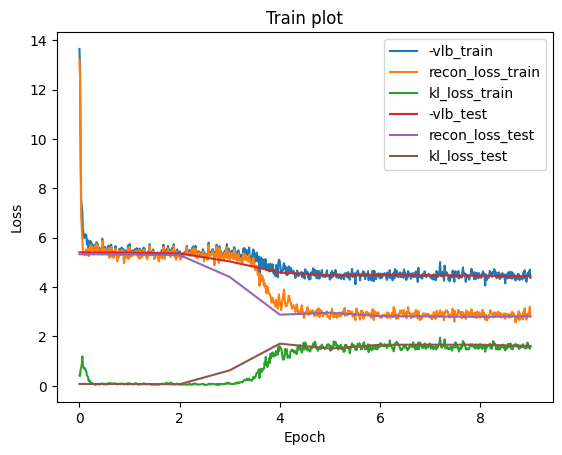

In [ ]:
# training routine
model = FullyConnectedVAE(2, 2, [128, 128], [128, 128])
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data, batch_size=128)
train_losses, test_losses = train(model, train_loader, test_loader, epochs=10, lr=1e-3)
train_losses = np.stack((train_losses['loss'], train_losses['recon_loss'], train_losses['kl_loss']), axis=1)
test_losses = np.stack((test_losses['loss'], test_losses['recon_loss'], test_losses['kl_loss']), axis=1)
plot_vae_training_plot(train_losses, test_losses, title="Train plot")

##### 2.2.1.5 VAE Sampling (0.25 pts)

Sample 1000 values using your VAE model. Visualize both latent and generated variables. Compare distribution of generated values with data distribution. Comment on your results.

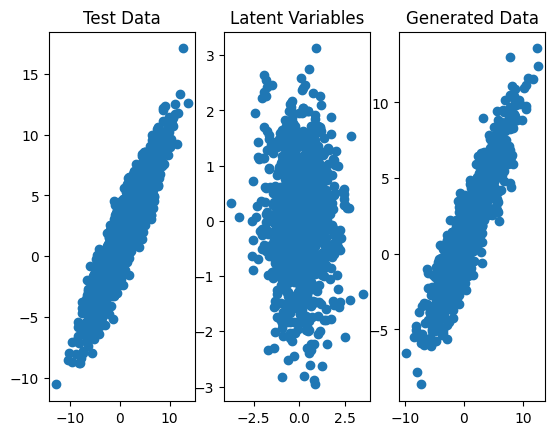

In [ ]:
# ========= YOUR CODE STARTS HERE ========= #
latent, generated = model.sample(1000)
latent = latent.detach()
generated = generated.detach()

_, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.set_title('Test Data')
ax1.scatter(test_data[:, 0], test_data[:, 1])

ax2.set_title('Latent Variables')
ax2.scatter(latent[:, 0], latent[:, 1])

ax3.set_title('Generated Data')
ax3.scatter(generated[ :, 0], generated[:, 1])
plt.show()
# ========== YOUR CODE ENDS HERE ========== #

#### 2.2.2 VAEs on Images (1.5 pts)

In this question, you will train CNN (Convolutional Neural Network) version of VAE on image dataset (SVHN) and analyze it properties.

Please download dataset from [here](https://drive.google.com/drive/folders/1ICMh3Zz2hG23WcrjYANRk14Iqm8lC0I9?usp=sharing).

Firstly, let's load and visualize our data:

In [15]:
def load_image_data(fname: str) -> Tuple[np.ndarray, np.ndarray]:
    with open(fname, 'rb') as f:
        data = pickle.load(f)

    train_data, test_data = data['train'], data['test']
    if 'mnist.pkl' in fname or 'shapes.pkl' in fname:
        train_data = (train_data > 127.5).astype('uint8')
        test_data = (test_data > 127.5).astype('uint8')
    return train_data, test_data

train_data, test_data = load_image_data("svhn.pkl")

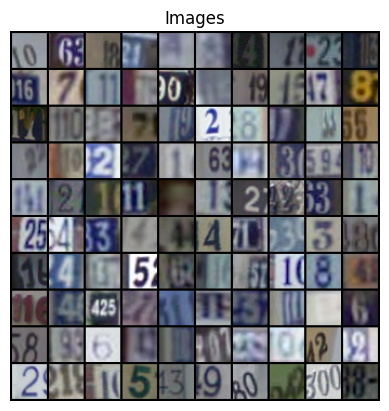

In [16]:
def visualize_images(images: np.ndarray):
    images = (torch.FloatTensor(images) / 255).permute(0, 3, 1, 2)
    grid_img = make_grid(images, nrow=10)
    plt.figure()
    plt.title("Images")
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.axis('off')
    plt.show()

def visualize_image_dataset(data: np.ndarray):
    idxs = np.random.choice(len(data), replace=False, size=(100,))
    images = data[idxs]
    visualize_images(images)

visualize_image_dataset(train_data)

##### 2.2.2.1 CNN VAE (0.5 pts)

Implement CNN VAE. Our latent variables $z$ dimensionality here will be 16. For a decoder $p_{\theta}(x|z) = \mathcal{N}(\mu_{\theta}(z), \Sigma_{\theta}(z))$ we will assume that $\Sigma_{\theta}(z) = I$ (we are not learning covariance of the decoder). The recommended architecture is following:

```
conv2d(in_channels, out_channels, kernel_size, stride, padding)
transpose_conv2d(in_channels, out_channels, kernel_size, stride, padding)
linear(in_dim, out_dim)
relu()
flatten()

Encoder
    conv2d(3, 32, 3, 1, 1)
    relu()
    conv2d(32, 64, 3, 2, 1) # 16 x 16
    relu()
    conv2d(64, 128, 3, 2, 1) # 8 x 8
    relu()
    conv2d(128, 256, 3, 2, 1) # 4 x 4
    relu()
    flatten() # 16
    linear(4 * 4 * 256, 2 * 16) # 16 - for mu and 16 - for sigma

Decoder
    linear(16, 4 * 4 * 128)
    relu()
    reshape(4, 4, 128)
    transpose_conv2d(128, 128, 4, 2, 1) # 8 x 8
    relu()
    transpose_conv2d(128, 64, 4, 2, 1) # 16 x 16
    relu()
    transpose_conv2d(64, 32, 4, 2, 1) # 32 x 32
    relu()
    conv2d(32, 3, 3, 1, 1)
```

*   when computing reconstruction loss, it suffices to just compute MSE between the reconstructed $x$ and true $x

In [59]:
class ConvDecoder(nn.Module):
    def __init__(self, latent_dim: int, output_shape: Tuple[int, int, int]):
        super().__init__()
        # ========= YOUR CODE STARTS HERE ========= #
        self.layers = nn.Sequential(
            nn.Linear(latent_dim, 128 * 4 * 4),
            nn.ReLU(),
            nn.Unflatten(1, (128, 4, 4)),
            nn.ConvTranspose2d(128, 128, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 3, 1, 1)
        )
        # ========== YOUR CODE ENDS HERE ========== #

    def forward(self, z: torch.Tensor) -> torch.Tensor:
        # ========= YOUR CODE STARTS HERE ========= #
        output = self.layers(z)
        # ========== YOUR CODE ENDS HERE ========== #
        return output


class ConvEncoder(nn.Module):
    def __init__(self, input_shape: Tuple[int, int, int], latent_dim: int):
        super().__init__()
        # ========= YOUR CODE STARTS HERE ========= #
        self.layers = nn.Sequential(
            nn.Conv2d(3, 32, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, 2, 1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, 2, 1),
            nn.ReLU(),
            nn.Conv2d(128, 256, 3, 2, 1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, 2 * latent_dim)
        )
        self.latent_dim = latent_dim
        # ========== YOUR CODE ENDS HERE ========== #

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        # ========= YOUR CODE STARTS HERE ========= #
        encoded = self.layers(x)
        mu, log_std = encoded[:, :self.latent_dim], encoded[:, self.latent_dim:]
        # ========== YOUR CODE ENDS HERE ========== #
        return mu, log_std


class ConvVAE(nn.Module):
    def __init__(self, input_shape: Tuple[int, int, int], latent_size: int):
        super().__init__()
        assert len(input_shape) == 3
        # ========= YOUR CODE STARTS HERE ========= #
        self.encoder = ConvEncoder(input_shape, latent_size)
        self.decoder = ConvDecoder(latent_size, input_shape)
        # ========== YOUR CODE ENDS HERE ========== #

    def reconstruction_loss(self, x: torch.Tensor, x_recon: torch.Tensor) -> torch.Tensor:
        # compute reconstruction loss as MSE between x and x_recon
        # ========= YOUR CODE STARTS HERE ========= #
        recon_loss = F.mse_loss(x, x_recon)
        # ========== YOUR CODE ENDS HERE ========== #
        return recon_loss

    def kl_loss(self, mu: torch.Tensor, log_std: torch.Tensor) -> torch.Tensor:
        # compute kl divergence between approximate posterior N(mu, Sigma) and prior N(0, I)
        # ========= YOUR CODE STARTS HERE ========= #
        batch_size = mu.shape[0]
        kl_loss = torch.mean(torch.stack([kl_div(mu[i], log_std[i]) for i in range(batch_size)]))
        # ========== YOUR CODE ENDS HERE ========== #
        return kl_loss

    def loss(self, x: torch.Tensor) -> OrderedDict[str, torch.Tensor]:
        # calculate loss as sum of reconstruction and kl-divergence losses
        # convert images to the [-1, 1] range
        # ========= YOUR CODE STARTS HERE ========= #
        x = x * 2. - 1.
        batch_size = x.shape[0]
        mu, log_std = self.encoder(x)
        z = torch.stack([mvn_sample(mu[i], log_std[i]) for i in range(batch_size)])
        x_recon = self.decoder(z)
        recon_loss = self.reconstruction_loss(x, x_recon)
        kl_loss = self.kl_loss(mu, log_std)
        # ========== YOUR CODE ENDS HERE ========== #
        return OrderedDict(loss=recon_loss + kl_loss, recon_loss=recon_loss,
                           kl_loss=kl_loss)

    def sample(self, n: int) -> np.ndarray:
        # implement sampling
        # convert images back from [-1, 1] scale to the [0, 1] scale
        with torch.no_grad():
            # ========= YOUR CODE STARTS HERE ========= #
            z = torch.randn((n, 16)).to(torch.device("cuda"))
            x = self.decoder(z)
            samples = (x + 1) / 2
            # ========== YOUR CODE ENDS HERE ========== #
        return samples.cpu()

##### 2.2.2.2 CNN VAE training (0.25 pts)

Train CNN VAE on the images data.

Note: on my laptop (Macbook M1 Pro) training took ~17 mins. If you want faster training, please do this lab in colab with GPU and move your model and data to the GPU ([.cuda()](https://pytorch.org/docs/stable/generated/torch.Tensor.cuda.html#torch.Tensor.cuda) call)

In [18]:
train_data = (np.transpose(train_data, (0, 3, 1, 2)) / 255.).astype('float32')
test_data = (np.transpose(test_data, (0, 3, 1, 2)) / 255.).astype('float32')

In [19]:
torch.cuda.device_count()

1

EPOCH 0 started
EPOCH 1 started
EPOCH 2 started
EPOCH 3 started
EPOCH 4 started
EPOCH 5 started
EPOCH 6 started
EPOCH 7 started
EPOCH 8 started
EPOCH 9 started


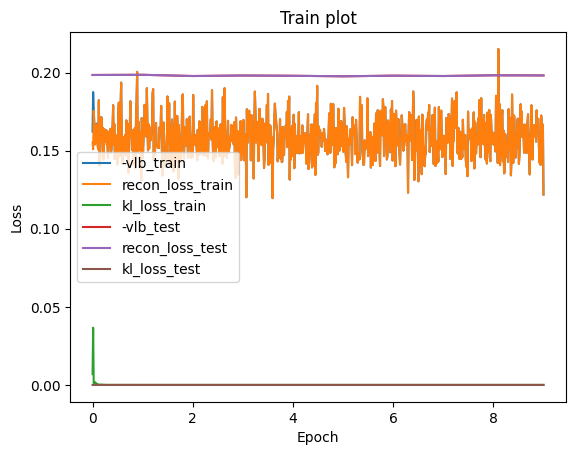

In [64]:
model = ConvVAE((3, 32, 32), 16).to(torch.device(0))
train_loader = DataLoader(torch.tensor(train_data).to(torch.device("cuda")), batch_size=128, shuffle=True)
test_loader = DataLoader(torch.tensor(test_data).to(torch.device("cuda")), batch_size=128)
# train_losses, test_losses = train(model, train_loader, test_loader, epochs=20, lr=1e-3)
train_losses, test_losses = train(model, train_loader, test_loader, epochs=10, lr=1e-3)
train_losses = np.stack((train_losses['loss'], train_losses['recon_loss'], train_losses['kl_loss']), axis=1)
test_losses = np.stack((test_losses['loss'], test_losses['recon_loss'], test_losses['kl_loss']), axis=1)
plot_vae_training_plot(train_losses, test_losses, title="Train plot")

##### 2.2.2.3 CNN VAE Sampling (0.25 pts)

Sample 100 images using your CNN VAE model. Visualize them.

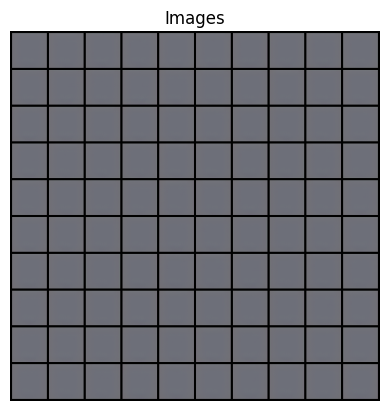

In [66]:
# ========= YOUR CODE STARTS HERE ========= #
images = (model.sample(100).detach().permute(0, 2, 3, 1).numpy()) * 255
visualize_images(images)
# ========== YOUR CODE ENDS HERE ========== #

##### 2.2.2.4 CNN VAE Interpolation (0.5 pts)

Take 10 image pairs ($I_1, I_2$) (20 images in total) from the test dataset. Convert them to latent codes ($z_1, z_2$) via VAE Encoder. For each pair, calculate 10 interpolations (including $z_1$ and $z_2$) of latent codes, which are distributed uniformly along the $z_1 \rightarrow z_2$ line. Decode this interpolations and visualize them. Explain results.

In [82]:
model.encoder(test_data_tensor[pair_index[0]].unsqueeze(0))[0][0]

tensor([-1.4777e-05,  6.0743e-05, -1.3892e-05, -1.0935e-04, -9.5882e-05,
        -8.4261e-06,  6.5934e-06, -6.5138e-05, -4.7922e-05,  6.0094e-05,
        -5.8702e-05, -1.0669e-05,  1.8060e-05, -7.2634e-06,  9.1485e-05,
         3.9562e-05], device='cuda:0', grad_fn=<SelectBackward0>)

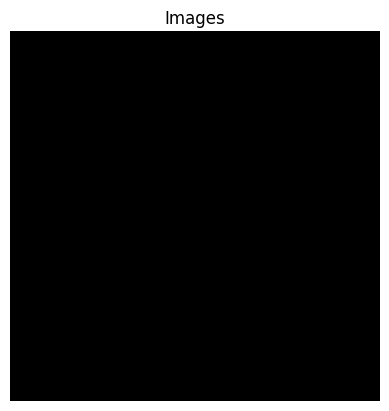

In [87]:
# ========= YOUR CODE STARTS HERE ========= #
model.eval()
test_data_tensor = torch.FloatTensor(test_data).to(torch.device("cuda"))

num_pairs = 10
pair_indices = np.random.randint(0, len(test_data), size=(num_pairs, 2))
num_steps = 10

interpolated_images = []
for pair_index in pair_indices:
    z1, z2 = model.encoder(test_data_tensor[pair_index[0]].unsqueeze(0)), model.encoder(test_data_tensor[pair_index[0]].unsqueeze(0))
    z1, z2 = mvn_sample(z1[0][0], z1[1][0]), mvn_sample(z2[0][0], z2[1][0])
    t = torch.linspace(0, 1, num_steps).unsqueeze(1).to(torch.device("cuda"))
    interpolated_z = t * z1 + (1 - t) * z2
    decoded_images = model.decoder(interpolated_z).detach().permute(0, 2, 3, 1).cpu().numpy()
    interpolated_images.extend(decoded_images)

visualize_images(np.array(interpolated_images))

# ========== YOUR CODE ENDS HERE ========== #

### 2.2.3 Summary (0.25 pts)

* Summarize in a few sentences what you have learned and achieved by completing the tasks of this assignment. Comment on how this assignment can be imporved in the future.

We have implemented variational autoencoder architecture for a 2-dimensional distribution and for images. The main feature of our models is that they implement a version of Latent Variable Models, which have an encoder, that encodes an image into a latent space of dimensionality $k$, where all the encoded datapoints are standard normally distributed due to KL diverence of encoded variables being a part of our loss function. Then, to generate a sample we pick a point from latent space and run a decoder on this point. Decoder is trained to learn how datapoints from latent space are related to real images.

The fact that we use KL divergence as our loss makes it possible to *group* similar images in similar space in latent space. This makes it possible to interpolate, i.e. gradually move from one type of images/datapoints to another type of images or datapoints, by moving over a line in latent space step by step and decode a datapoint at each step

#### 2.2.4 Hierarchical VAE (Additional!) (up to 1.5 pts)

In this part, we will explore a simplified version of the hierarchical VAE described in [NVAE](https://arxiv.org/pdf/2007.03898.pdf). We will not implement the full NVAE, but rather use some ideas from the paper to explore how to learn a prior distribution $p_Z(z)$.

Implement a hierarchical VAE that follows the following structure.
* $z1$ is a 2x2x12 latent vector where $p(z_1)$ is the unit Gaussian.
    * Learn the approximate posterior $q_\phi(z|x) = N(z; \mu_\phi(x), \Sigma_\phi(x))$, where $\mu_\phi(x)$ is the mean vector, and $\Sigma_\phi(x)$ is a diagonal covariance matrix. I.e., same as a normal VAE, but use a matrix latent rather than a vector. Each dimension is independent.
* $z2$ is a 2x2x12 latent vector.
    * $p_\theta(z2|z1)$ is learned, and implemented as a neural network that parameterizes mean (and log std, optionally).
    * $q_\theta(z2|z1,x)$ is also learned. Implement this as a Residual Normal [see NVAE] over the prior $p_\theta(z2|z1)$.
* The decoder should be a function of $z2$ only.

Some helpful hints:
* Two KL losses should be calculated. The first should match $q_\phi(z|x)$ to the unit Gaussian. The second should match $q_\phi(z2|z1,x)$ and $p_\theta(z2|z1)$, and be taken with respect to $q$.
* When calculating the second KL term, utilize the analytic form for the residual normal. When $q_\phi(z2|z1,x) = N(z2; \mu_\phi(z1) + \Delta \mu_\phi(z1,x), \Sigma_\phi(z1)) * \Delta \Sigma_\phi(z1,x))$, use the following form: `kl_z2 = -z2_residual_logstd - 0.5 + (torch.exp(2 * z2_residual_logstd) + z2_residual_mu ** 2) * 0.5`
* When calculating KL, remember to sum over the dimensions of the latent variable before taking the mean over batch.
* For the prior $p_\theta(z2|z1)$, fix standard deviation to be 1. Learn only the mean. This will help with stability in training.